# Solution 1

## FINM 37500 - 2023

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from binomial import *

In [2]:
dt = .5
T = 1
rate_tree,style_tree = construct_rate_tree(dt,T)

rate_tree[.5] = [.0339,.0095]
rate_tree.loc[0,0] = .0174
style_tree

time,0.0,0.5
state,,
0,1.74%,3.39%
1,,0.95%


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [3]:
maturities = [.5,1,1.5]
prices = [99.1338,97.8925,96.1462]
quotes, style_quotes = construct_quotes(maturities,prices)
style_quotes

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


This is the current term-structure observed at $t=0$.

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.

### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?

### 1.4 
What is the price of the swap?

# **<span style="color:red">Solution 1</span>**

In [4]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

### Parameters

In [5]:
MATUND = 1
FACE = 100

### Calculate tree for bond with $T=1$

In [6]:
bond_tree = pd.DataFrame(dtype=float, index=rate_tree.index, columns=rate_tree.columns)

for i in bond_tree.columns[-1:0:-1]:
    bond_tree[i] = np.exp(-rate_tree[i]*(MATUND-i)) * FACE

bond_tree.iloc[0,0] = quotes.loc[MATUND,'price']
bond_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

time,0.0,0.5
state,,
0,97.8925,98.3193
1,nan,99.5261


### Calculate $p^*$

In [7]:
A = np.exp(rate_tree.iloc[0,0] * dt)
Z = np.exp(-rate_tree.iloc[0,0] * dt)

pstar = (A * bond_tree.loc[0,0] - bond_tree.loc[1,dt])/(bond_tree.loc[0,dt] - bond_tree.loc[1,dt])

pvec = pd.DataFrame([pstar,1-pstar],index=['prob up','prob down'],columns=[''])
pvec.style.format('{:.2%}')

,
prob up,64.49%
prob down,35.51%


### Swap tree

In [8]:
STRIKE = .02
payoff = lambda r: FACE/2 * (r-STRIKE)
swap_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns, dtype=float)
swap_tree[dt] = payoff(rate_tree[dt])

### Replicating portfolio

The replicating portfolios are listed below for pedagogy. Given the risk-neutral probabilities, they are not needed to calculate the price.

In [9]:
def replicating_port(prices,under_tree,deriv_tree,dt,FACE=100):
    delta = (deriv_tree.loc[0,dt] - deriv_tree.loc[1,dt]) / (under_tree.loc[0,dt] - under_tree.loc[1,dt]) 
    cash = (deriv_tree.loc[0,dt] - delta * under_tree.loc[0,dt]) / FACE
    
    out = pd.DataFrame({'positions':[cash,delta], 'value':prices},index=['cash','under'])
    out.loc['derivative','value'] = out['positions'] @ out['value']
    return out

In [10]:
replicating_port(quotes.loc[[.5,1],'price'].values, bond_tree, swap_tree, dt=.5).style.format('{:.4f}')

,positions,value
cash,1.0009,99.1338
under,-1.0109,97.8925
derivative,nan,0.2595


### Calculate Swap Value

In [11]:
swap_tree.loc[0,0] = Z * np.array([pstar,1-pstar])@ swap_tree[dt].values
swap_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

time,0.0,0.5
state,,
0,0.2595,0.6950
1,nan,-0.5250


***

# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the followign interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

### 2.1
Display the tree of swap prices.

### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

# **<span style="color:red">Solution 2</span>**

### Swap tree

See the swap tree above.

In [12]:
EXPIRATION = .5
SWAPMAT = 1
STRIKE = .02
payoff = lambda r: FACE * np.maximum(STRIKE - r,0)

### Estimating $p^*$

We determine $p^*$ with the market quotes, which we have on the zero-coupon bonds, along with the rate tree. Accordingly, we get the same $p^*$ here.

If we had market quotes to calibrate the swap prices, then we could use those to estimate $p^*$.

In [13]:
pstars = estimate_pstar(quotes.loc[:SWAPMAT,['price']],rate_tree)
pstars.name = 'pstar'
pstars.to_frame().T.style.format('{:.2%}').format_index('{:.2f}',axis=1)

time,0.00
pstar,64.49%


### Pricing with $p^*$

Using the formulas in a few lines of explicit code...

In [14]:
floorlet_tree = pd.DataFrame(dtype=float, columns=rate_tree.columns, index=rate_tree.index)
floorlet_tree[EXPIRATION] = payoff(rate_tree[EXPIRATION])
floorlet_tree.loc[0,0] = Z * np.array([pstar, 1-pstar])@floorlet_tree[EXPIRATION]
floorlet_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

time,0.0,0.5
state,,
0,0.3697,0.0000
1,nan,1.0500


Using a function

In [15]:
deriv_tree = bintree_pricing(payoff, rate_tree, rate_tree, pstars)
deriv_tree.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.50
state,,
0,0.3697,0.0000
1,,1.0500


This price matches the value from the replicating portfolio using the swaps.

### Pricing with replicating portfolio

In [16]:
replicating_port([quotes.loc[.5,'price'],swap_tree.loc[0,0]], swap_tree, floorlet_tree, dt=.5).style.format('{:.4f}')

,positions,value
cash,0.0060,99.1338
under,-0.8607,0.2595
derivative,nan,0.3697


***

# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)

### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

# **<span style="color:red">Solution 3</span>**

In [17]:
payoff = lambda p: np.maximum(p-STRIKE,0)
STRIKE = 99
EXPIRATION = .5
BONDMAT = 1

under_tree = bond_tree

deriv_tree = pd.DataFrame(dtype=float, columns=under_tree.columns, index=under_tree.index)
deriv_tree[EXPIRATION] = payoff(under_tree[EXPIRATION])
deriv_tree.loc[0,0] = Z * np.array([pstar, 1-pstar]) @ deriv_tree[EXPIRATION]
deriv_tree.style.format('{:.4f}').format_index('{:.1f}',axis=1)

time,0.0,0.5
state,,
0,0.1852,0.0000
1,nan,0.5261


In [18]:
replicating_port(quotes.loc[[.5,1],'price'].values, bond_tree, deriv_tree, dt=.5).style.format('{:.4f}')

,positions,value
cash,-0.4286,99.1338
under,0.4360,97.8925
derivative,nan,0.1852


In [19]:
pstars = estimate_pstar(quotes.loc[:BONDMAT,['price']],rate_tree)
pstars.name = 'pstar'
pstars.to_frame().T.style.format('{:.2%}').format_index('{:.2f}',axis=1)

time,0.00
pstar,64.49%


In [20]:
deriv_tree = bintree_pricing(payoff, rate_tree, bond_tree, pstars)
deriv_tree.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.50
state,,
0,0.1852,0.0000
1,,0.5261


***

# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [21]:
new_col = pd.Series([.05,.0256,.0011],name=1)
rate_tree_multi = pd.concat([rate_tree,new_col],axis=1)
rate_tree_multi.index.name = 'state'
rate_tree_multi.columns.name = 'time'
rate_tree_multi.style.format('{:.2%}',na_rep='').format_index('{:.1f}',axis=1)

time,0.0,0.5,1.0
state,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

### 4.3
Calculate the price of the European put option?
* option expires at $T_{\text{deriv}}=1$
* written on bond maturing at $T_{\text{bond}}=1.5$
* strike = 99

### 4.4
Re-do 4.3 but for an American-style option.
* What is its value at $t=0$?
* Which nodes would you exercise it early?

# **<span style="color:red">Solution 4</span>**

In [22]:
pstars = estimate_pstar(quotes,rate_tree_multi)

dt = rate_tree_multi.columns[1] - rate_tree_multi.columns[0]
payoff = lambda r: payoff_bond(r,dt)

bond_tree_multi = bintree_pricing(payoff, rate_tree_multi, rate_tree_multi, pstars)
bond_tree_multi.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.50,1.00
state,,,
0,96.1462,96.1426,97.5310
1,,98.5184,98.7282
2,,,99.9450


### Put on bond

In [23]:
STRIKE = 99
payoff = lambda p: np.maximum(STRIKE-p,0)

deriv_tree = bintree_pricing(payoff, rate_tree_multi, bond_tree_multi, pstars)
deriv_tree.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.50,1.00
state,,,
0,0.8379,1.1935,1.4690
1,,0.2129,0.2718
2,,,0.0000


### American 

In [24]:
deriv_tree = bintree_pricing(payoff, rate_tree_multi, bond_tree_multi, pstars, style='american')
deriv_tree.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.50,1.00
state,,,
0,2.8538,2.8574,1.4690
1,,0.4816,0.2718
2,,,0.0000


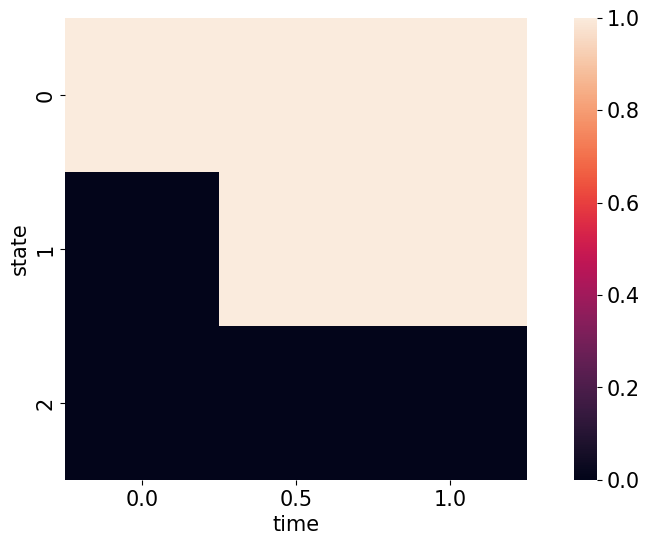

In [25]:
exer = (deriv_tree == payoff(bond_tree_multi)) & (deriv_tree > 0)
sns.heatmap(exer,square=True);

***

# 5 American Style

## *Optional: no need to submit this solution.*

Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

### 5.1
Using this smaller time step, compute the $t=0$ price of the put option in part 4:
* option expires at $T_{\text{deriv}}=1$
* written on bond maturing at $T_{\text{bond}}=1.5$
* strike of \$99

### 5.2
Price the same option with the finer time grid, but now for an American exercise
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

# **<span style="color:red">Solution 5</span>**

### Building the rate tree

We immediately have questions about how to build the rate tree.

1. Multiplicative up/down factors as in the lecture note.
2. Additive up/down factors trying t

For either of these choices...
* Should we match vol of rates or levels of rates?
* How far out do we need to model the rates?

Given that the bond matures at $T=1.5$, we need to model rates out to (one step less than) that maturity. 
* Do either of the choices above lead to reasonable choices out to $T=1.5$?

In [26]:
dt = 1/30
Topt = 1.5

SIM_ADDITIVE = False

if SIM_ADDITIVE:
    sigma = .01
    mu_growth = .0050
    up = mu_growth * dt + sigma * np.sqrt(dt)
    down = mu_growth * dt - sigma * np.sqrt(dt)/2
else:
    sigma = .30
    up = np.exp(sigma*np.sqrt(dt))
    down = np.exp(-sigma*np.sqrt(dt))

rate_tree_finer = rate_tree_multi[[0]].copy()

for t in range(1,int(1/dt)+1):
    if SIM_ADDITIVE:
        rate_tree_finer[t] = rate_tree_finer[t-1] + up
        rate_tree_finer.loc[t,t] = rate_tree_finer.loc[t-1,t-1] + down
    else:
        rate_tree_finer[t] = rate_tree_finer[t-1] * up        
        rate_tree_finer.loc[t,t] = rate_tree_finer.loc[t-1,t-1] * down

rate_tree_finer.columns *= dt * Topt

rate_tree_finer.iloc[:21,:21].style.format('{:.2%}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
state,,,,,,,,,,,,,,,,,,,,,
0,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%
1,,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%
2,,,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%
3,,,,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%
4,,,,,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%
5,,,,,,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%
6,,,,,,,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%
7,,,,,,,,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%
8,,,,,,,,,1.12%,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%


### Risk-neutral probability

In order to estimate $p^*$ at each step, we would need a market quote for a bond maturing at each time-step maturity.

We do not have this, so we try pricing by assuming a constant $p^*$ throughout the tree, equal to the first $p^*$ we estimated at $t=0$.

In [27]:
pstars = pd.Series(pstars.loc[0],index=rate_tree_finer.columns[0:-1])
pstars.name = 'p star'
pstars.to_frame().T.style.format('{:.2%}').format_index('{:.2f}',axis=1)

time,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00,1.05,1.10,1.15,1.20,1.25,1.30,1.35,1.40,1.45
p star,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%,64.49%


### Pricing the bond over the tree

In [28]:
bond_tree_finer = bintree_pricing(payoff, rate_tree_finer, rate_tree_finer, pstars)
bond_tree_finer.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00,1.05,1.10,1.15,1.20,1.25,1.30,1.35,1.40,1.45,1.50
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,95.6755,95.6368,95.6015,95.5700,95.5427,95.5201,95.5027,95.4910,95.4856,95.4871,95.4963,95.5137,95.5401,95.5765,95.6237,95.6826,95.7543,95.8399,95.9405,96.0575,96.1923,96.3463,96.5212,96.7186,96.9404,97.1887,97.4657,97.7736,98.1151,98.4929,98.9100
1,,95.9802,95.9485,95.9201,95.8956,95.8753,95.8596,95.8491,95.8443,95.8456,95.8538,95.8695,95.8933,95.9261,95.9685,96.0215,96.0860,96.1630,96.2535,96.3587,96.4799,96.6183,96.7754,96.9528,97.1521,97.3751,97.6238,97.9002,98.2066,98.5454,98.9194
2,,,96.2606,96.2351,96.2130,96.1948,96.1807,96.1712,96.1669,96.1681,96.1755,96.1896,96.2110,96.2405,96.2786,96.3263,96.3843,96.4535,96.5348,96.6294,96.7383,96.8627,97.0039,97.1632,97.3422,97.5425,97.7657,98.0137,98.2886,98.5925,98.9277
3,,,,96.5182,96.4984,96.4820,96.4693,96.4609,96.4569,96.4581,96.4647,96.4774,96.4966,96.5231,96.5574,96.6003,96.6524,96.7146,96.7877,96.8727,96.9705,97.0823,97.2091,97.3522,97.5129,97.6927,97.8930,98.1156,98.3622,98.6347,98.9352
4,,,,,96.7549,96.7402,96.7288,96.7212,96.7177,96.7187,96.7247,96.7361,96.7534,96.7772,96.8080,96.8465,96.8933,96.9492,97.0149,97.0913,97.1791,97.2795,97.3934,97.5219,97.6662,97.8275,98.0073,98.2070,98.4282,98.6725,98.9419
5,,,,,,96.9722,96.9620,96.9551,96.9520,96.9529,96.9582,96.9685,96.9840,97.0054,97.0331,97.0677,97.1098,97.1600,97.2190,97.2876,97.3665,97.4566,97.5589,97.6742,97.8037,97.9485,98.1098,98.2890,98.4873,98.7065,98.9480
6,,,,,,,97.1714,97.1653,97.1624,97.1633,97.1681,97.1773,97.1913,97.2105,97.2353,97.2664,97.3042,97.3493,97.4023,97.4638,97.5347,97.6156,97.7074,97.8109,97.9272,98.0571,98.2018,98.3625,98.5404,98.7369,98.9534
7,,,,,,,,97.3540,97.3515,97.3522,97.3565,97.3648,97.3774,97.3946,97.4169,97.4448,97.4788,97.5192,97.5668,97.6221,97.6857,97.7584,97.8407,97.9337,98.0379,98.1545,98.2843,98.4285,98.5880,98.7641,98.9582
8,,,,,,,,,97.5212,97.5219,97.5258,97.5332,97.5445,97.5599,97.5800,97.6050,97.6355,97.6718,97.7146,97.7642,97.8213,97.8865,97.9604,98.0438,98.1373,98.2419,98.3584,98.4876,98.6307,98.7886,98.9625


### Price the derivative

In [29]:
STRIKE = 99
EXPIRATION = 1

payoff = lambda p: np.maximum(p-STRIKE,0)

In [30]:
deriv_tree = bintree_pricing(payoff, rate_tree_finer.loc[:,:EXPIRATION].dropna(axis=0,how='all'), bond_tree_finer.loc[:,:EXPIRATION].dropna(axis=0,how='all'), pstars)
deriv_tree.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
state,,,,,,,,,,,,,,,,,,,,,
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,,,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,,,,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Note that the price is now 0 at every node!
* This is a consequence of our model of the finer-tree rates not being consistent with the original rate tree.
* We have not gained accuracy with this attempt at a finer grid but rather changed the model.
* The fact we guessed $p^*$ here is not the main issue. Try other values for $p^*$ above, and for a wide range you will get this consequence.

### Price the American style

In [31]:
deriv_tree = bintree_pricing(payoff, rate_tree_finer.loc[:,:EXPIRATION].dropna(axis=0,how='all'), bond_tree_finer.loc[:,:EXPIRATION].dropna(axis=0,how='all'), pstars, style='american')
deriv_tree.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
state,,,,,,,,,,,,,,,,,,,,,
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,,,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,,,,,,,,,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


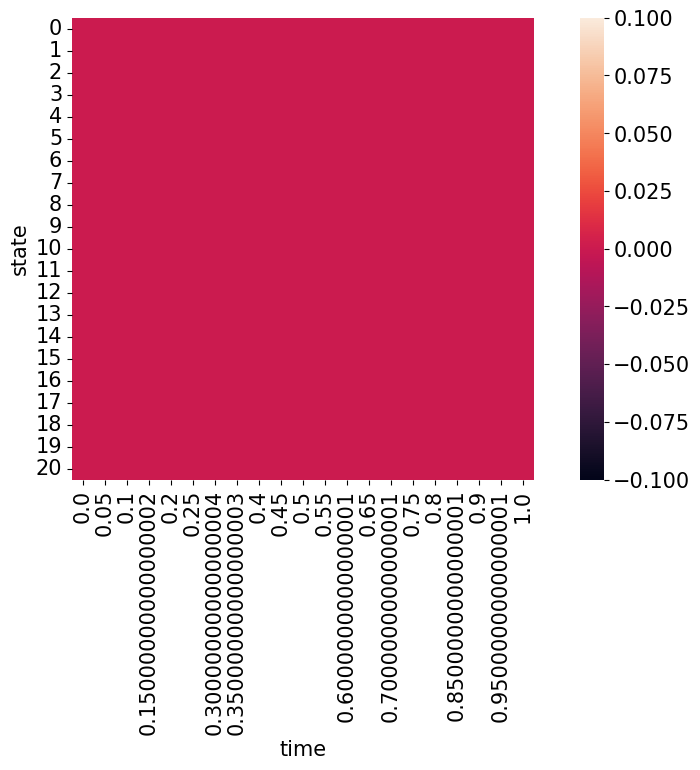

In [32]:
exer = (deriv_tree.loc[:,:EXPIRATION].dropna(axis=0,how='all') == payoff(bond_tree_finer.loc[:,:EXPIRATION].dropna(axis=0,how='all'))) & (deriv_tree.loc[:,:EXPIRATION].dropna(axis=0,how='all') > 0)
sns.heatmap(exer,square=True);

# Extra

## Pricing other derivatives: Straddle

In [33]:
STRIKE = 98.7282
payoff = lambda p: np.maximum(p-STRIKE,0) + np.maximum(STRIKE-p,0)

deriv_tree = bintree_pricing(payoff, rate_tree_multi, bond_tree_multi, pstars)
deriv_tree.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.50,1.00
state,,,
0,0.6367,0.7591,1.1972
1,,0.4301,0.0000
2,,,1.2168


In [34]:
STRIKE = 98.7282
payoff = lambda p: np.maximum(p-STRIKE,0) + np.maximum(STRIKE-p,0)

deriv_tree = bintree_pricing(payoff, rate_tree_multi, bond_tree_multi, pstars, style='american')
deriv_tree.style.format('{:.4f}',na_rep='').format_index('{:.2f}',axis=1)

time,0.00,0.50,1.00
state,,,
0,2.5820,2.5856,1.1972
1,,0.4301,0.0000
2,,,1.2168


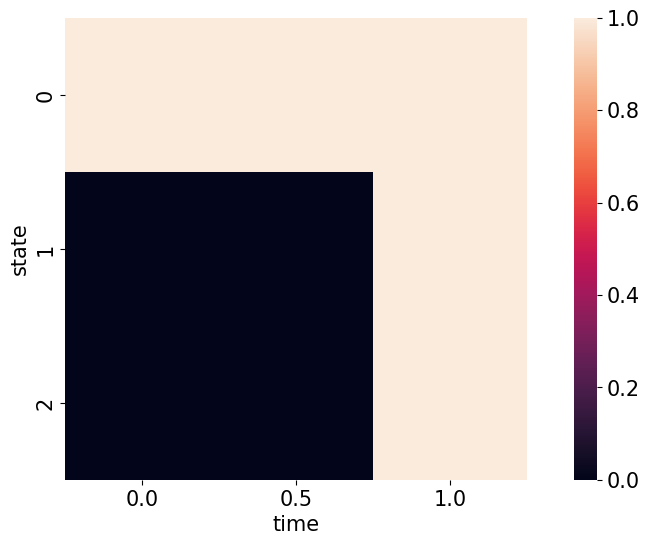

In [35]:
exer = (deriv_tree == payoff(bond_tree_multi)) & (deriv_tree > 0)
sns.heatmap(exer,square=True);